### Reading and visualizing model continuum spectra

The model data are stored in the HDF5 format (.h5). This Ipython notebook provides a simple code to read and visualize the model continuum spectra.

The model free parameters are the luminosity $L$ and the reference density $\rho_{\rm ref}$. This is reflected in the file names. For example, ``public_spectra/spherespec_l6d-12.0.h5`` is a file for the luminosity $L=L_{\rm Edd}(10^6~M_\odot)=1.47\times10^{44}{\rm~erg~s^{-1}}$ and $\rho_{\rm ref}=10^{-12.0}{\rm~g~cm^{-3}}$.

Each file includes three 1D datasets: the luminosity `L_nu` (unit: $\rm erg~s^{-1}~Hz^{-1}$), the frequency `freq` (unit: Hz), and the wavelength `wavelen` (unit: Angstrom). The length of `L_nu` is 122, and the lengths of `freq` and `wavelen` are 123: they give the left and right edges of each wavelength bin, and `L_nu` is the multigroup luminosity averaged over each bin.

If you have any questions, feel free to contact the corresponding author of the paper, Hanpu Liu.

**Dependencies: numpy, matplotlib, scipy, [h5py](https://www.h5py.org/) (optionally, [seaborn](https://seaborn.pydata.org/) for color palette)**

Reference: H. Liu et al. (2025), [arxiv:2507.07190](https://arxiv.org/abs/2507.07190)

In [1]:
# load dependencies
from matplotlib import pyplot as plt
import h5py
from seaborn import color_palette

### Load one spectrum

Spherical accretion flow model spectrum (Liu et al. 2025). 
Attributes: log luminosity (L_Edd(M/M_sun) ), log reference density (g/cm^3). 
Datasets: rest-frequency (Hz), rest-wavelength (cm), luminosity L_nu (erg/s/Hz).
Log luminosity [L_Edd(M/Msun)]: 6
Log reference density [g/cm^3]: -12.0
Datasets: ['L_nu', 'freq', 'wavelen']


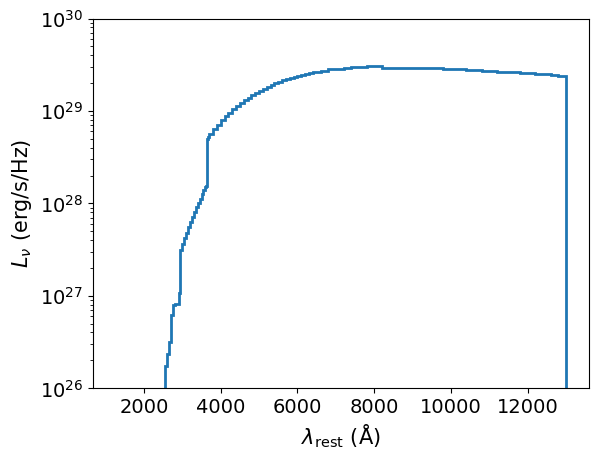

In [2]:
# change the path to your directory if needed
spec_directory = 'public_spectra/'
filename = spec_directory + 'spherespec_l6d-12.0.h5'
with h5py.File(filename, 'r') as f:
    print(f.attrs['message'])
    print('Log luminosity [L_Edd(M/Msun)]:', f.attrs['log_l'])
    print('Log reference density [g/cm^3]:', f.attrs['log_rho_ref'])
    print('Datasets:', list(f.keys()))  # print the keys in the file
    # load the data
    l_nu = f['L_nu'][:]
    wavelen = f['wavelen'][:]

# visualize the data
fig, ax = plt.subplots()
ax.stairs(l_nu, wavelen,linewidth=2)
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda_{\rm rest}\ ({\rm \AA}$)', fontsize=15)
ax.set_ylabel(r'$L_\nu\ ({\rm erg/s/Hz})$', fontsize=15)
ax.set_ylim(1e26,1e30)
ax.tick_params(labelsize=14)

### Reproduce Fig. 7 (excluding observed spectra)

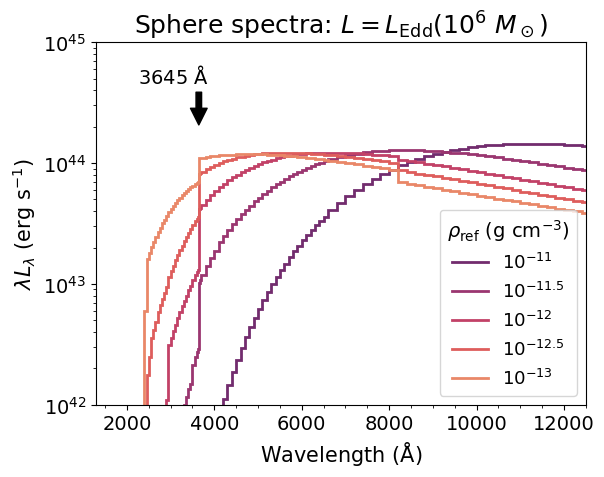

In [3]:
rho_ref_list = [-11,-11.5,-12,-12.5,-13]
palette = color_palette("flare_r",n_colors=len(rho_ref_list))
fig1, ax1 = plt.subplots()

for i, rho_ref in enumerate(rho_ref_list):
    filename = spec_directory + 'spherespec_l6d%05.1f.h5'%rho_ref
    # load the data from the file
    with h5py.File(filename, 'r') as f:
        l_nu = f['L_nu'][:]
        wavelen = f['wavelen'][:]
        freq = f['freq'][:]
    # from bin edge to center
    wavelen_center = (wavelen[1:] + wavelen[:-1]) / 2
    # calculate nu*L_nu. 3.0e18 is the speed of light in Angstroms per second
    nu_l_nu = l_nu * 3.0e18 / wavelen_center
    # plot the spectra
    ax1.stairs(nu_l_nu, wavelen, color=palette[i], linewidth=2, label=r'$10^{%g}$' % rho_ref)
# bells and whistles
ax1.annotate(r'', xy=(3645, 2e44), xytext=(3645, 4e44),
             arrowprops=dict(color='black', shrink=0.05))
ax1.annotate(r'$3645{\rm~\AA}$', xy=(2250, 4.6e44),fontsize=14,color='black')
ax1.set_title(r'Sphere spectra: $L=L_{\rm Edd}(10^6~M_\odot)$', fontsize=18)
ax1.set_xlabel(r'Wavelength$~({\rm \AA})$',fontsize=15)
ax1.set_ylabel(r'$\lambda L_\lambda~({\rm erg~s^{-1}})$',fontsize=15)
ax1.tick_params(labelsize=14)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(500))
ax1.legend(fontsize=13,loc='lower right',title=r'$\rho_{\rm ref}~(\rm g~cm^{-3})$',title_fontsize=14)
ax1.set_yscale('log')
ax1.set_ylim(1e42,1e45)
ax1.set_xlim(1300,12500)
fig1.subplots_adjust(bottom=0.125,left=0.135)
plt.show()

### Reproducing Fig. 9 (excluding observed spectra)

This example is useful for those who would like to interpolate the model spectrum in the parameter space.

/var/folders/jm/x_tnzyks1rvf6glsbxncphn00000gn/T/ipykernel_48214/4020622986.py:27: RuntimeWarning: divide by zero encountered in log10
  nulnu_interp[i] = 10**interpn((logl_array, logrho_over_sqrtm_array[::-1]), np.log10(nulnu_array_3D[:,::-1,i]),


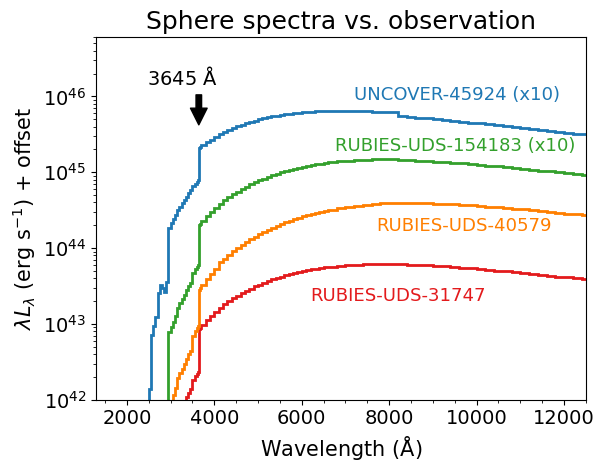

In [ ]:
import numpy as np
from scipy.interpolate import interpn

# interpolate from the spectrum
def interpspec(l, rho_ref, nulnu_array_3D):
    """
    Interpolate the spectrum at a given luminosity and reference density.
    Parameters
    ----------
    l : float
        Luminosity in L_Edd(Msun).
    rho_ref: float
        Reference density in g/cm^3.
    nulnu_array_3D : numpy.ndarray
        A 3D array of shape (rho_ref_all.shape[0], rho_ref_all.shape[1], nbin) containing the model grid of spectra.
    Returns
    -------
    nulnu_interp : numpy.ndarray
        A 1D array of interpolated spectrum at the given luminosity and reference density.
    """
    # interpolation is done in log l -- log (rho_ref / sqrt(l)) space
    logl_array = np.array([5.0, 6.0, 7.0])
    logrho_over_sqrtm_array = np.array([-14.0, -14.5, -15.0, -15.5, -16.0])
    nbin = nulnu_array_3D.shape[-1]
    nulnu_interp = np.zeros(shape=(nbin,))
    for i in range(nbin):
        nulnu_interp[i] = 10**interpn((logl_array, logrho_over_sqrtm_array[::-1]), np.log10(nulnu_array_3D[:,::-1,i]),
                                       (np.log10(l), np.log10(rho_ref/np.sqrt(l))), method='linear')[0]
    return nulnu_interp


# load all model spectra into a 3D array
rho_ref_all = np.array([[-11.5, -12.0, -12.5, -13.0, -13.5],
                        [-11.0, -11.5, -12.0, -12.5, -13.0],
                        [-10.5, -11.0, -11.5, -12.0, -12.5],])
logl_all = np.array([5.0, 6.0, 7.0])
nbin = 122    # number of wavelength bins
nulnu_array_3D = np.zeros(shape=(logl_all.shape[0], rho_ref_all.shape[1], nbin))
for i in range(logl_all.shape[0]):
    for j in range(rho_ref_all.shape[1]):
        logl = logl_all[i]
        logrhoref = rho_ref_all[i, j]
        filename = spec_directory + 'spherespec_l%dd%05.1f.h5'%(logl, logrhoref)
        # load the data from the file
        with h5py.File(filename, 'r') as f:
            l_nu = f['L_nu'][:]
            wavelen = f['wavelen'][:]
        # from bin edge to center
        wavelen_center = (wavelen[1:] + wavelen[:-1]) / 2
        nu_l_nu = l_nu * 3.0e18 / wavelen_center
        nulnu_array_3D[i, j, :] = nu_l_nu


# parameters matching the observed spectra
l_fit_array = np.array([5e6, 1.2e6, 5e5, 3e6])
rhoref_fit_array = np.array([2.0e-12, 2.3e-12, 1.6e-12, 5.5e-12])
offset_factor_array = np.array([10, 10, 1, 1])
palette1 = color_palette("Paired",n_colors=len(l_fit_array)*2)[1::2]
fig2, ax2 = plt.subplots()
for i in range(len(l_fit_array)):
    l_fit = l_fit_array[i]
    rhoref_fit = rhoref_fit_array[i]
    offset_factor = offset_factor_array[i]
    # this step interpolates from the model grid to the desired 
    # luminosity and reference density to match observations
    nulnu_interp = interpspec(l_fit, rhoref_fit, nulnu_array_3D)
    ax2.stairs(nulnu_interp * offset_factor, wavelen, color=palette1[i], linewidth=2)
# bells and whistles
ax2.annotate(r'', xy=(3645, 4e45), xytext=(3645, 1.1e46),
             arrowprops=dict(color='black', shrink=0.05))
ax2.annotate(r'$3645{\rm~\AA}$', xy=(2450, 1.4e46),fontsize=14,color='black')
ax2.annotate('UNCOVER-45924 (x10)', xy=(7200, 9.0e45),fontsize=13,color=palette1[0])
ax2.annotate(r'RUBIES-UDS-154183 (x10)', xy=(6750, 1.9e45),fontsize=13,color=palette1[1])
ax2.annotate(r'RUBIES-UDS-31747', xy=(6200, 2.0e43),fontsize=13,color=palette1[2])
ax2.annotate(r'RUBIES-UDS-40579', xy=(7700, 1.66e44),fontsize=13,color=palette1[3])
ax2.set_title(r'Sphere spectra vs. observation', fontsize=18)
ax2.set_xlabel(r'Wavelength$~({\rm \AA})$',fontsize=15)
ax2.set_ylabel(r'$\lambda L_\lambda~({\rm erg~s^{-1}})$ + offset',fontsize=15)
ax2.tick_params(labelsize=14)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(500))
ax2.set_yscale('log')
ax2.set_ylim(1e42,6e46)
ax2.set_xlim(1300,12500)
fig2.subplots_adjust(bottom=0.125,left=0.135)
plt.show()